# R1 Lateralization analysis on the patterns

- load participant pattern per time
- group into left and right, calculate difference R-L
- plot the difference over time
- bring to group level

In [1]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys 

base_dir = "/u/kroma/PRAWN/"
os.chdir(base_dir)

In [51]:
import json

with open('sessions.json', 'r') as file:
    data = json.load(file)
    sessions = data["allsessions_prediction"]

sessions = sorted(list(set([i[:7] for i in sessions])))
sessions = [i for i in sessions if "90" not in i] # 2 adult pilots

sessions

['sub-001',
 'sub-002',
 'sub-003',
 'sub-004',
 'sub-005',
 'sub-006',
 'sub-007',
 'sub-008',
 'sub-009',
 'sub-010',
 'sub-012',
 'sub-013',
 'sub-014',
 'sub-015',
 'sub-016',
 'sub-017',
 'sub-019',
 'sub-020',
 'sub-021',
 'sub-022',
 'sub-023',
 'sub-024',
 'sub-025',
 'sub-026',
 'sub-028',
 'sub-030',
 'sub-032',
 'sub-033',
 'sub-034',
 'sub-035',
 'sub-036',
 'sub-038',
 'sub-039',
 'sub-040',
 'sub-041',
 'sub-042',
 'sub-043',
 'sub-044']

In [19]:
# 1 sub
sub = "sub-001"
# load pattern fif
pattern = mne.read_evokeds(f"{base_dir}/models/{sub}/timeresolved_interpret/inter_patterns-ave.fif")
pattern = pattern[0]

Reading /u/kroma/PRAWN/models/sub-001/timeresolved_interpret/inter_patterns-ave.fif ...
    Found the data of interest:
        t =    -400.00 ...    1000.00 ms (No comment)
        0 CTF compensation matrices available
        nave = 1 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.
No baseline correction applied


In [21]:
pattern.get_data(tmin=0.).shape

(31, 251)

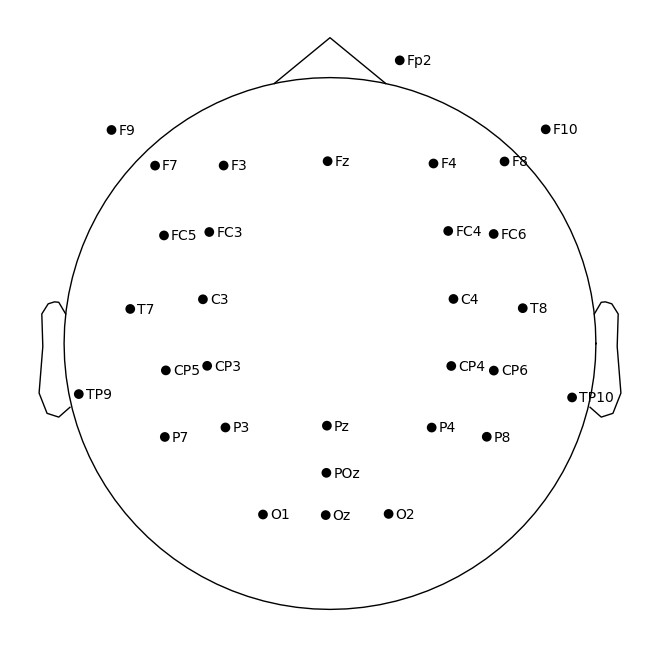

In [22]:
mne.viz.plot_sensors(pattern.info, kind='topomap', show_names=True, show=False)
plt.show()

In [ ]:
# # Define left and right channel picks (you can customize these)
# left_chs = mne.pick_channels_regexp(pattern.info['ch_names'], '.*[FCTPO].*?([1,3,5,7,9]$|[L])')
# right_chs = mne.pick_channels_regexp(pattern.info['ch_names'], '.*[FCTPO].*?([2,4,6,8,10]$|[R])')
# # Sanity check: match the number of channels
# left_names = sorted([pattern.ch_names[i] for i in left_chs])
# right_names = sorted([pattern.ch_names[i] for i in right_chs])
# # is fault, manually resorted it

In [43]:
left_roi = ['CP3',
 'CP5',
 'O1',
 'P3',
 'P7',
 'TP9']
right_roi = ['CP4',
 'CP6',
 'O2',
 'P4',
 'P8',
 'TP10'] # TODO: think about only posterior electrodes at all!
left = ['C3',
 'CP3',
 'CP5',
 'O1',
 'P3',
 'P7',
 'T7',
 'TP9']
right = ['C4',
 'CP4',
 'CP6',
 'F4',
 'F8',
 'FC4',
 'FC6',
 'O2',
 'P4',
 'P8',
 'T8',
 'TP10'] # TODO: think about only posterior electrodes at all!

## loop across subs

In [53]:
dflat = []
for sub in sessions:
    # load pattern fif
    pattern = mne.read_evokeds(f"{base_dir}/models/{sub}/timeresolved_interpret/inter_patterns-ave.fif")
    pattern = pattern[0]

    # for each pair, get the difference

    lateralization = []
    for r,l in zip(right_roi, left_roi):
        # get the data
        r_data = pattern.get_data(picks=[r], tmin=0.)
        l_data = pattern.get_data(picks=[l], tmin=0.)
        # get the difference
        lateralization.append(r_data - l_data)
    lateralization = np.array(lateralization)
    lateralization = lateralization.mean(axis=0).transpose().squeeze()
    
    this_dflat = pd.DataFrame({
    'time': pattern.times[100:],
    'lateralization': lateralization,
    'participant': sub,
    })
    dflat.append(this_dflat)
dflat = pd.concat(dflat, ignore_index=True)

Reading /u/kroma/PRAWN/models/sub-001/timeresolved_interpret/inter_patterns-ave.fif ...
    Found the data of interest:
        t =    -400.00 ...    1000.00 ms (No comment)
        0 CTF compensation matrices available
        nave = 1 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.
No baseline correction applied
Reading /u/kroma/PRAWN/models/sub-002/timeresolved_interpret/inter_patterns-ave.fif ...
    Found the data of interest:
        t =    -400.00 ...    1000.00 ms (No comment)
        0 CTF compensation matrices available
        nave = 1 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.
No baseline correction applied
Reading /u/kroma/PRAWN/models/sub-003/timeresolved_interpret/inter_patterns-ave.fif ...
    Found the data of interest:
        t =    -400.00 ...    1000.00 ms (No comment)
        0 CTF compensation matrices available
        nave = 1 - aspect type = 100
N

(251,)

## Plot

In [67]:
#sns.lineplot(data=dflat, x="time", y="lateralization", hue="participant", palette="tab10", linewidth=2.5) #ci=0.95, err_style="band")

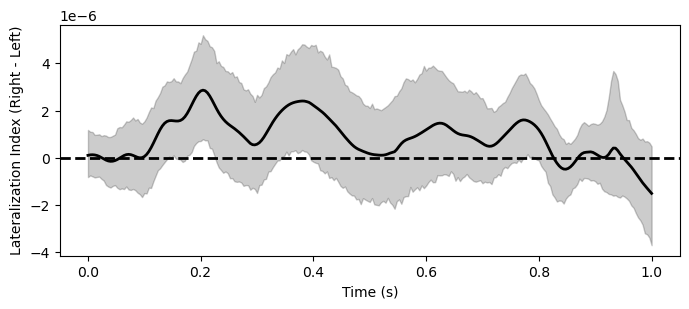

In [68]:
# define plot size
plt.figure(figsize=(8, 3))
sns.lineplot(data=dflat, x="time", y="lateralization", linewidth=2, ci=95, err_style="band", color="black") #palette="black", 
plt.axhline(0, color='k', linestyle='--', linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Lateralization Index (Right - Left)")
plt.savefig(f"{base_dir}/plots/lateralization.png", bbox_inches='tight', dpi=300)
plt.show()

## Stats

- avg across time per participant
- test against 0

In [82]:
dflatavg = dflat #dflat[(dflat['time'] > 0.15) & (dflat['time'] < 0.75)].copy()
dflatavg = dflatavg.groupby('participant').mean().reset_index()

In [83]:
dflatavg

,participant,time,lateralization
0,sub-001,0.5,-2.383889e-08
1,sub-002,0.5,-2.492857e-06
2,sub-003,0.5,5.959838e-06
3,sub-004,0.5,-3.323077e-07
4,sub-005,0.5,2.816272e-06
5,sub-006,0.5,-2.210702e-07
6,sub-007,0.5,8.891973e-07
7,sub-008,0.5,2.748402e-06
8,sub-009,0.5,-1.188673e-06
9,sub-010,0.5,3.741680e-06


<Axes: ylabel='lateralization'>

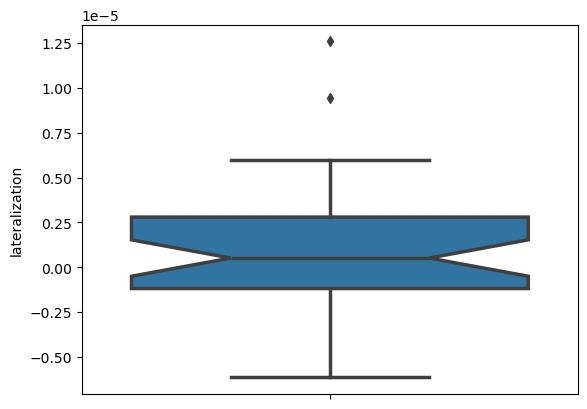

In [84]:
sns.boxplot(data=dflatavg, y="lateralization", palette="tab10", linewidth=2.5, notch=True)

In [ ]:
# one sample t-test against 0
from scipy import stats
t_stat, p_val = stats.ttest_1samp(dflatavg['lateralization'], 0, alternative = "two-sided")
df = len(dflatavg['lateralization']) - 1
# Format p-value (APA style often reports p < .001 if it's very small)
p_str = f"p = {p_val:.3f}" if p_val >= 0.001 else "p < .001"

# Print 
print(f"t({df}) = {t_stat:.2f}, {p_str}")

t(37) = 1.35, p = 0.185
